# Count By Segmentation: Baseline

This note demonstrates how to count cell colonies on plates of growth medium. It uses convolutional neural networks to perform image segmentation; some postprocessing steps turn these image segmentations into counts. The neural network architecture is that of Valen et al. (see `/readings/Valen et al.md`).

In [1]:
VERSION = 18

In [2]:
import sys, importlib

sys.path.append("../..")

%matplotlib inline

# Dataset

We will use the `easy` dataset.

To understand the dataset, first read the following definition.

> A mask $M$ of an image $I$ for the condition $c$ is a grayscale image of the same dimensions as $I$ such that:
> 1. $M[y, x]$ is black if $c$ is true of $I[y, x]$
> 2. $M[y, x]$ is white otherwise

Each example in the `easy` dataset is dervied from a single plate and consists of:
1. a $2448px \times 2448px$ RGB image of the plate, plus a bit of surrounding table
2. an mask of (1) for the condition that the pixel lies within, but not on the edge of, a cell colony
3. an mask of (1) for the condition that the pixel lies on the edge of a cell colony
4. an mask of (1) for the condition that the pixel outside of all cell colonies

In [3]:
from src import dataset
importlib.reload(dataset)
import numpy as np

DATA_PATH = "data"

def transform(aspects):
    inp = np.stack((aspects["red"], aspects["green"], aspects["blue"]), axis=2)
    out = np.stack((aspects["inside"], aspects["edge"], aspects["outside"]), axis=2)
    return inp, out

easy = dataset.Dataset("data/main{0:d}".format(VERSION), 1)
easy.initialize_from_aspects("../../data/easy/data", transform)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


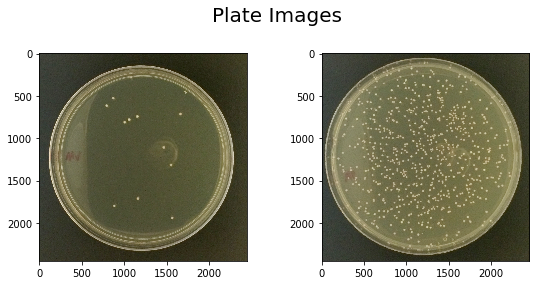

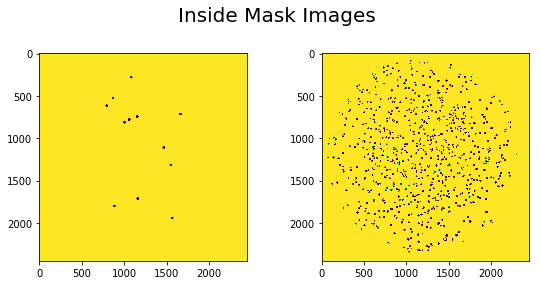

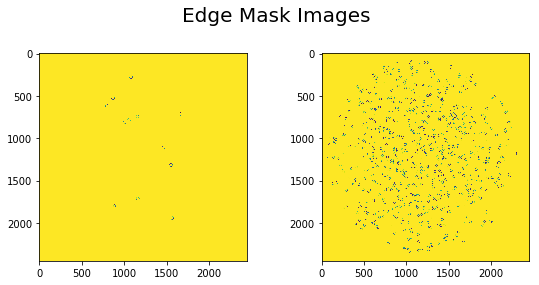

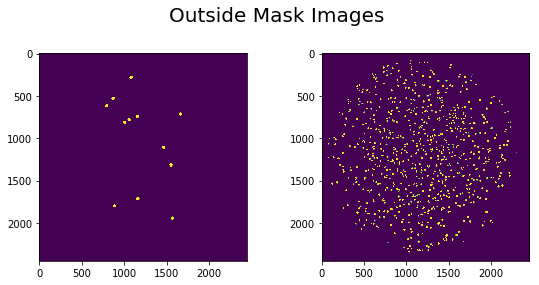

In [4]:
from src import visualization
importlib.reload(visualization)

NUM_IMAGES = 2
GRID_COLS = 2
IMAGE_SIZE = (4, 4)

inps, outs = easy.get_batch(NUM_IMAGES)
visualization.plot_images(inps, GRID_COLS, IMAGE_SIZE, "Plate Images")
visualization.plot_images(outs[..., 0], GRID_COLS, IMAGE_SIZE, "Inside Mask Images")
visualization.plot_images(outs[..., 1], GRID_COLS, IMAGE_SIZE, "Edge Mask Images")
visualization.plot_images(outs[..., 2], GRID_COLS, IMAGE_SIZE, "Outside Mask Images")

# Preprocessing

We resize each image to twice its original height and width. We do this because (1) the neural net must be supplied image patches whose width is a bit larger than a colony diameter, (2) the colonies in the images have diameters of at most about $30px$, and (3) the neural net architecture is fixed to accept image patches of width $61px$. The result is that the image patches of width $61px$ that we supply the neural net have width a bit larger than a colony diameter, as required.

In [5]:
from scipy import misc

DIMS = (2*2448, 2*2448)
INTERP_TYPE = "bicubic"

def resize(example):
    image, mask_image = example
    image = misc.imresize(image, DIMS, interp=INTERP_TYPE)
    mask_image = misc.imresize(mask_image, DIMS, interp=INTERP_TYPE)
    example = (image, mask_image)
    return [example]

easy.map(resize)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


We scale the values of the images to lie in the range $[0, 1]$ instead of their original range of $[0, 255]$.

In [6]:
RGB_MAX = 255

def rescale(example):
    image, mask_image = example
    image = image / RGB_MAX
    example = (image, mask_image)
    return [example]

easy.map(rescale)

From each image, we extract $100,000$ patches. Each patch is a $61px \times 61px$ part of the original image. The expected output for each patch is the class of its center pixel, either inside ($0$), edge ($1$), or outside ($2$).

We consider a pixel's class to be that of the mask whose value is darkest (nearest $0$) for that pixel. This detail is necessary because masks may:
1. fail to be mutually exclusive, with two masks being black for the same pixel, due to artifacts of their production
2. fail to be all-or-nothing, with a mask being neither black nor white, but gray, for some pixel, due to the effects of resizing

The patches we extract are sampled to eliminate class skewness in the image. This means that although the class distribution for the patches of the image may be something like `{"inside": 0.05, "edge": 0.05, "outside": 0.9"}`, the class distribution for the patches of the image we extract will be about `{"inside": 0.33, "edge": 0.33, "outside": 0.33"}`.

In [7]:
from src import preprocess
importlib.reload(preprocess)
import numpy as np

PATCH_SIZE = 61
MAX_PATCHES = 100_000
SEGMENT_SIZE = 1_000

def extract_patches(example):
    image, mask_image = example
    class_image = np.argmin(mask_image, axis=2)
    patches, classes = preprocess.extract_patches(image, class_image, PATCH_SIZE, max_patches=MAX_PATCHES)
    examples = []
    for i in range(patches.shape[0]):
        example = (patches[i, ...], classes[i])
        examples.append(example)
    return examples

easy.map(extract_patches)
easy.set_segment_size(SEGMENT_SIZE)

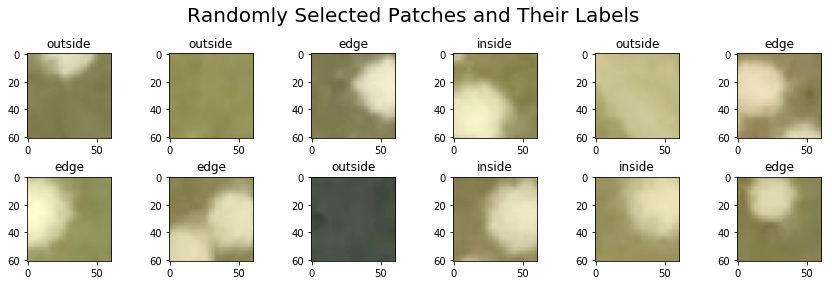

In [8]:
from src import visualization
importlib.reload(visualization)

NUM_IMAGES = 12
GRID_COLS = 6
IMAGE_SIZE = (2, 2)
CLASS_NAMES = {0:"inside", 1:"edge", 2:"outside"}
RGB_MAX = 255

images, classes = easy.get_batch(NUM_IMAGES)
images = images * RGB_MAX
subtitles = [CLASS_NAMES[classes[i]] for i in range(classes.shape[0])]
visualization.plot_images(images, GRID_COLS, IMAGE_SIZE, "Randomly Selected Patches and Their Labels", subtitles=subtitles)

We one-hot encode the classes, which involves assigning each patch, instead of a single correct class, an array where the $i$-th element represents how much the patch is in class $i$. In this case, we consider a patch to be in its correct class in the amount $1$ and in all other classes with amount $0$.

In [9]:
import numpy as np

NUM_CLASSES = 3

def one_hot_encode(batch):
    images, classes = batch
    one_hot_classes = np.zeros((classes.shape[0], NUM_CLASSES))
    one_hot_classes[np.arange(one_hot_classes.shape[0]), classes] = 1
    batch = (images, one_hot_classes)
    return batch

easy.map_batch(one_hot_encode)

We split the dataset into a training set and a test set.

In [10]:
TEST_FRAC = 0.1

train, test = easy.split(TEST_FRAC, "data/train{0:d}".format(VERSION), "data/test{0:d}".format(VERSION))

The following cell can be run instead of the preceding Preprocessing and Dataset sections, if one wishes to load a previously preprocessed dataset.

In [11]:
from src import dataset
importlib.reload(dataset)

train = dataset.Dataset("data/train{0:d}".format(VERSION))
test = dataset.Dataset("data/test{0:d}".format(VERSION))

# Training

Now we train a convolutional neural network to classify patches as inside, edge, or outside.

In [12]:
from models.segmentation.convnet1 import convnet1
importlib.reload(convnet1)

SAVE_INTERVAL = 5

model = convnet1.ConvNet1("model/{0:d}".format(VERSION), SAVE_INTERVAL, train.size())

In [13]:
from src import metric, utilities, losses
importlib.reload(metric)
importlib.reload(utilities)
importlib.reload(losses)
import tensorflow as tf

NUM_EXAMPLES = 1_000
NUM_CLASSES = 3

metrics_train = train.get_batch(NUM_EXAMPLES)
metrics_test = test.get_batch(NUM_EXAMPLES)
loss_fn = lambda actual, pred: utilities.tensor_eval(losses.make_cross_entropy_loss()(actual, pred))
metrics = {
    "train_loss": metric.LossMetric(metrics_train, loss_fn),
    "test_loss": metric.LossMetric(metrics_test, loss_fn),
    "conf_mtx": metric.ConfusionMatrixMetric(metrics_test, NUM_CLASSES),
    "nx_conf_mtx": metric.NonexclusiveConfusionMatrixMetric(metrics_test, NUM_CLASSES)
}

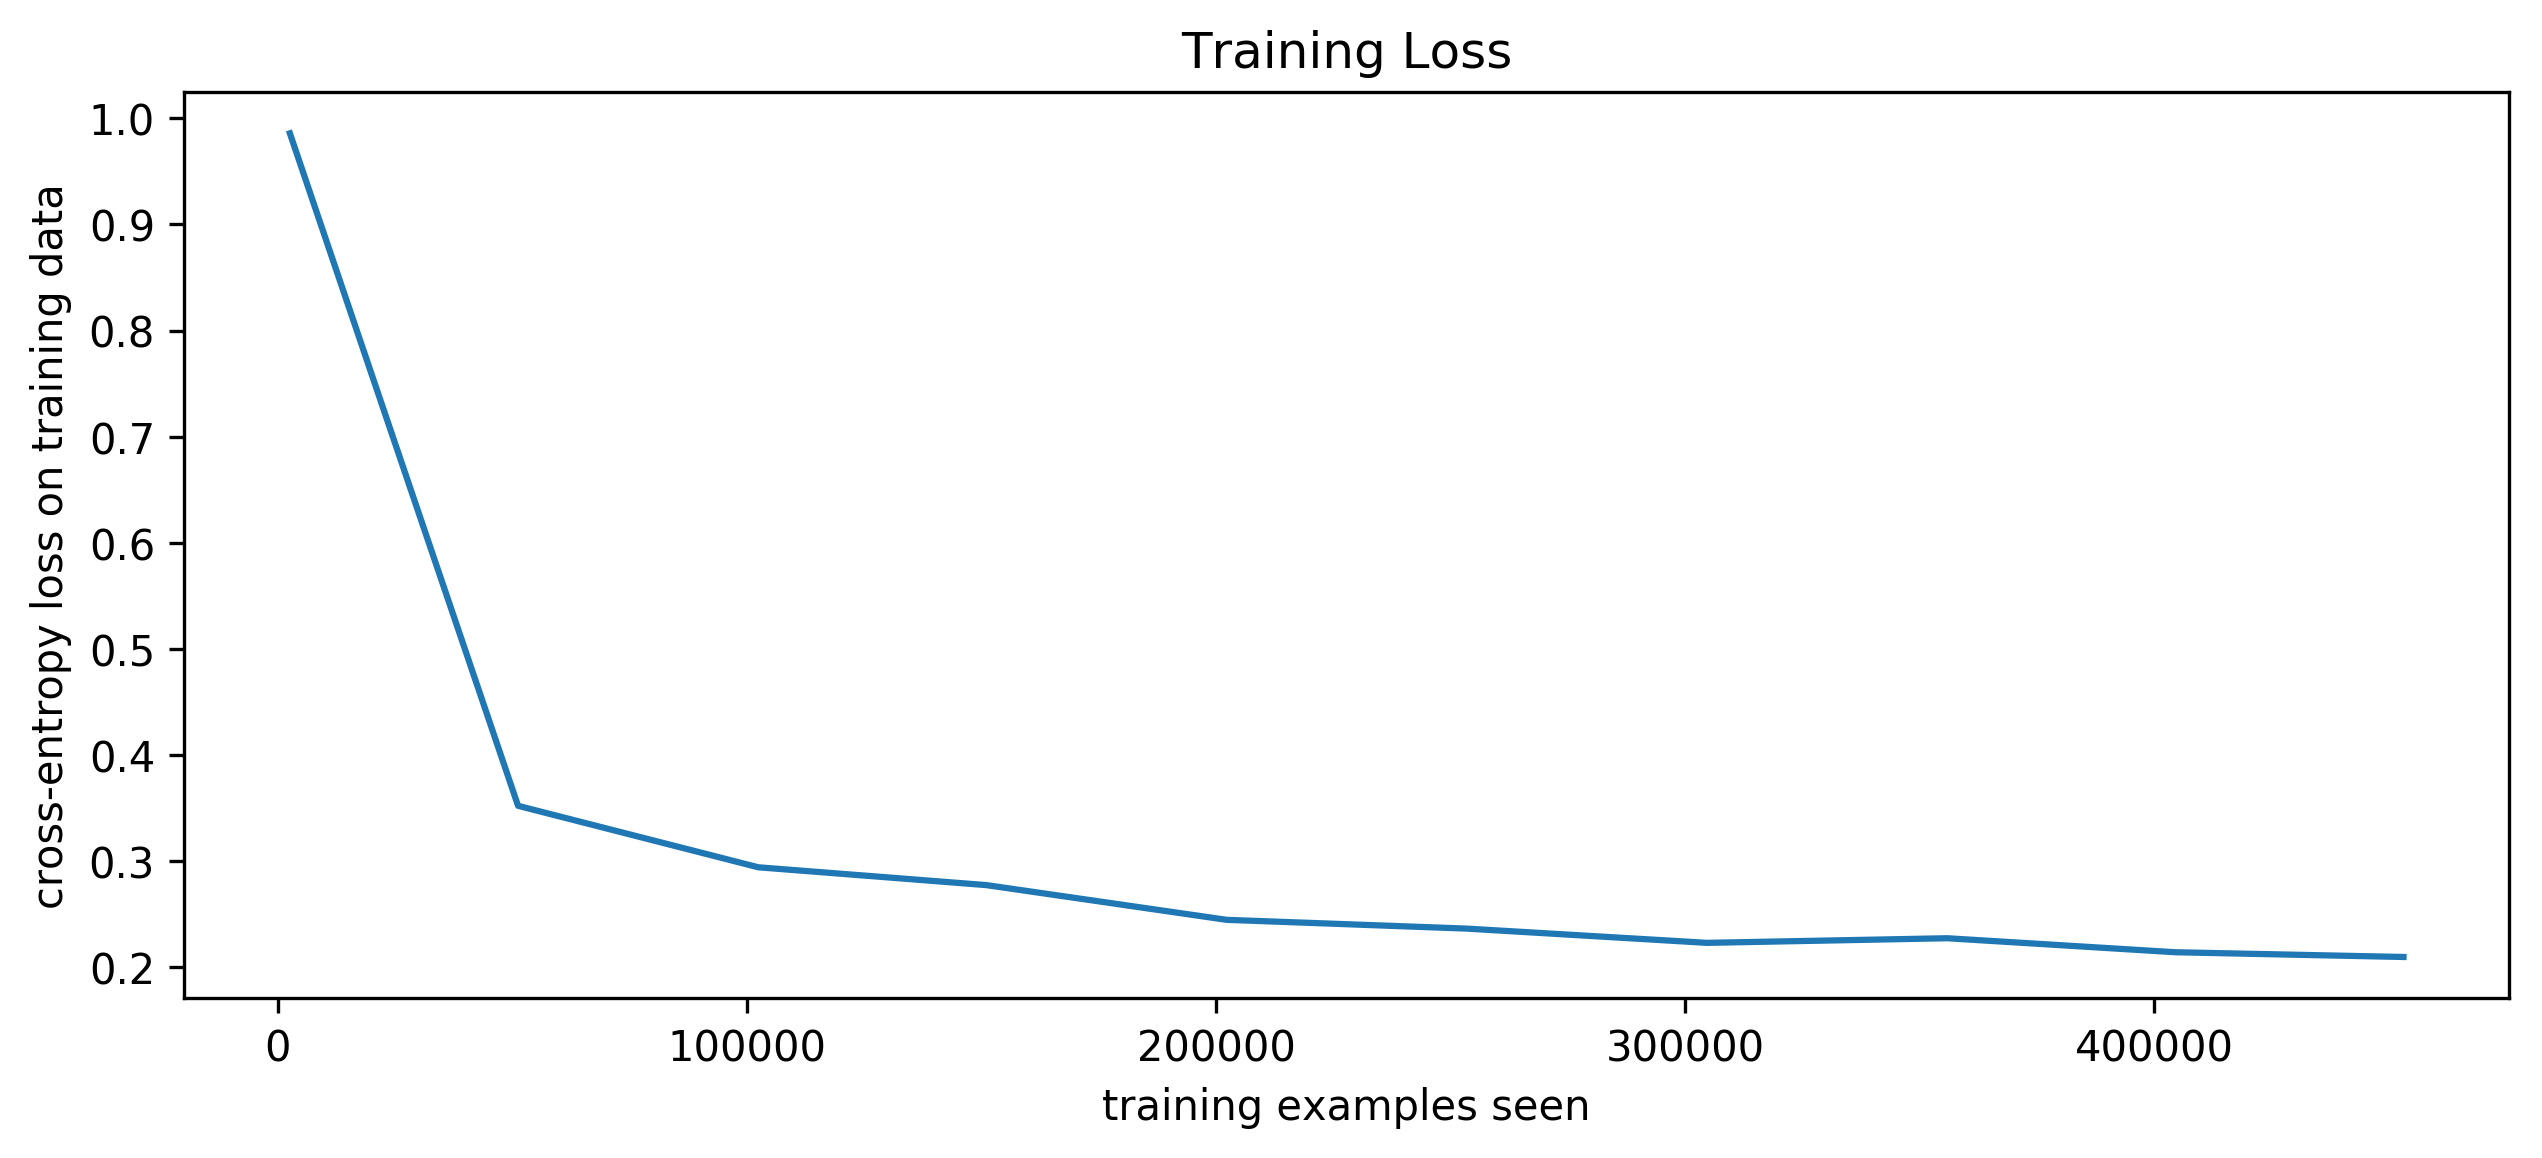

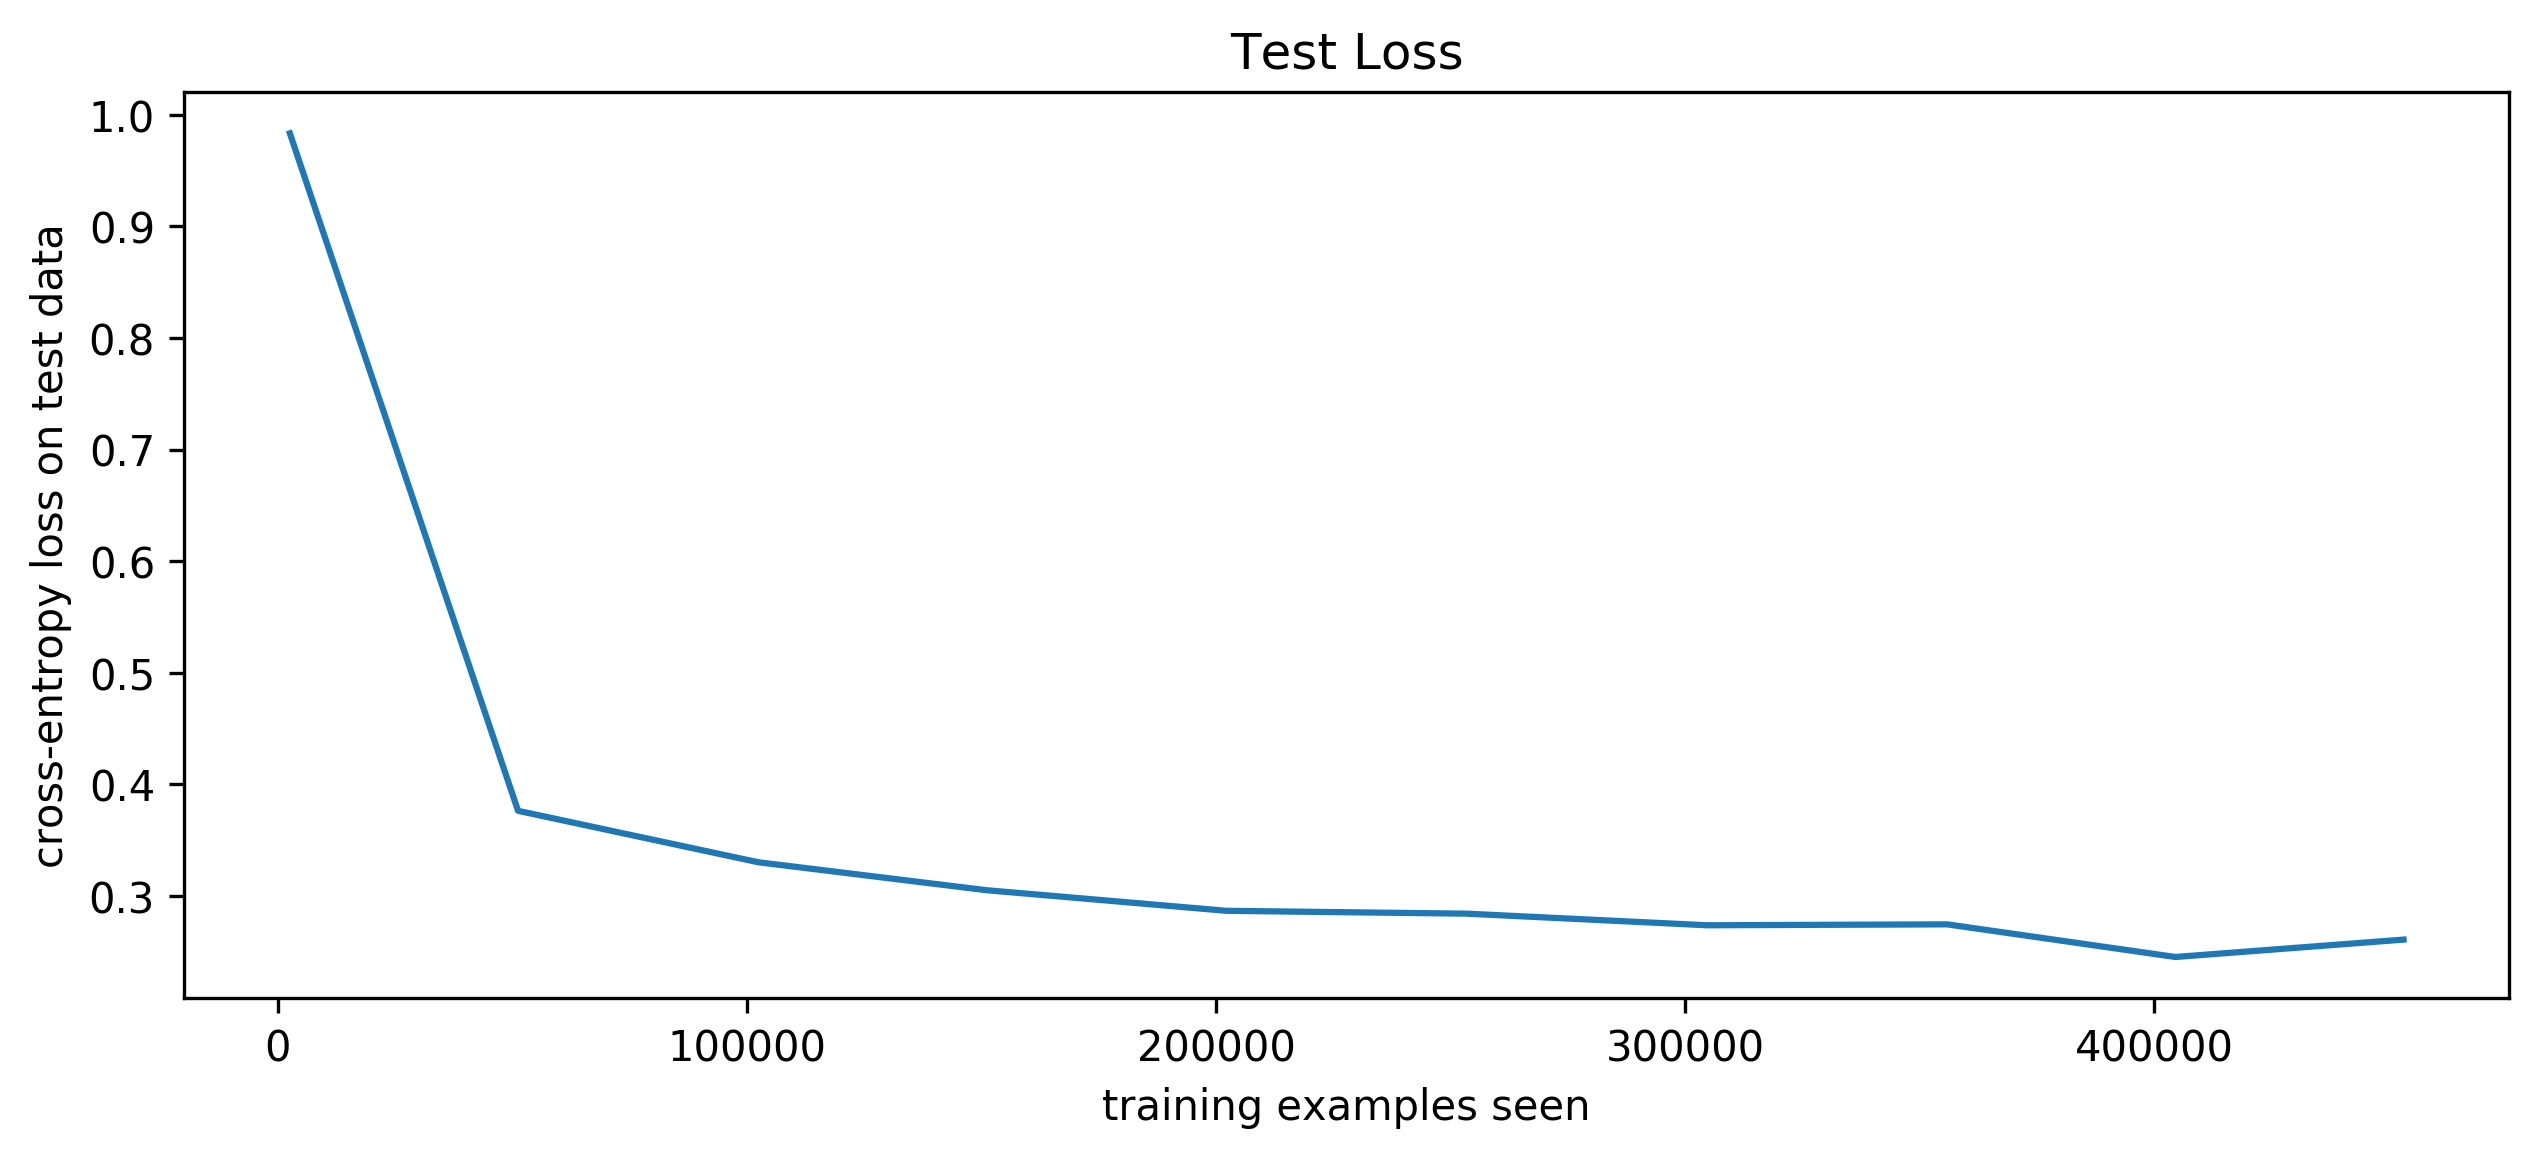

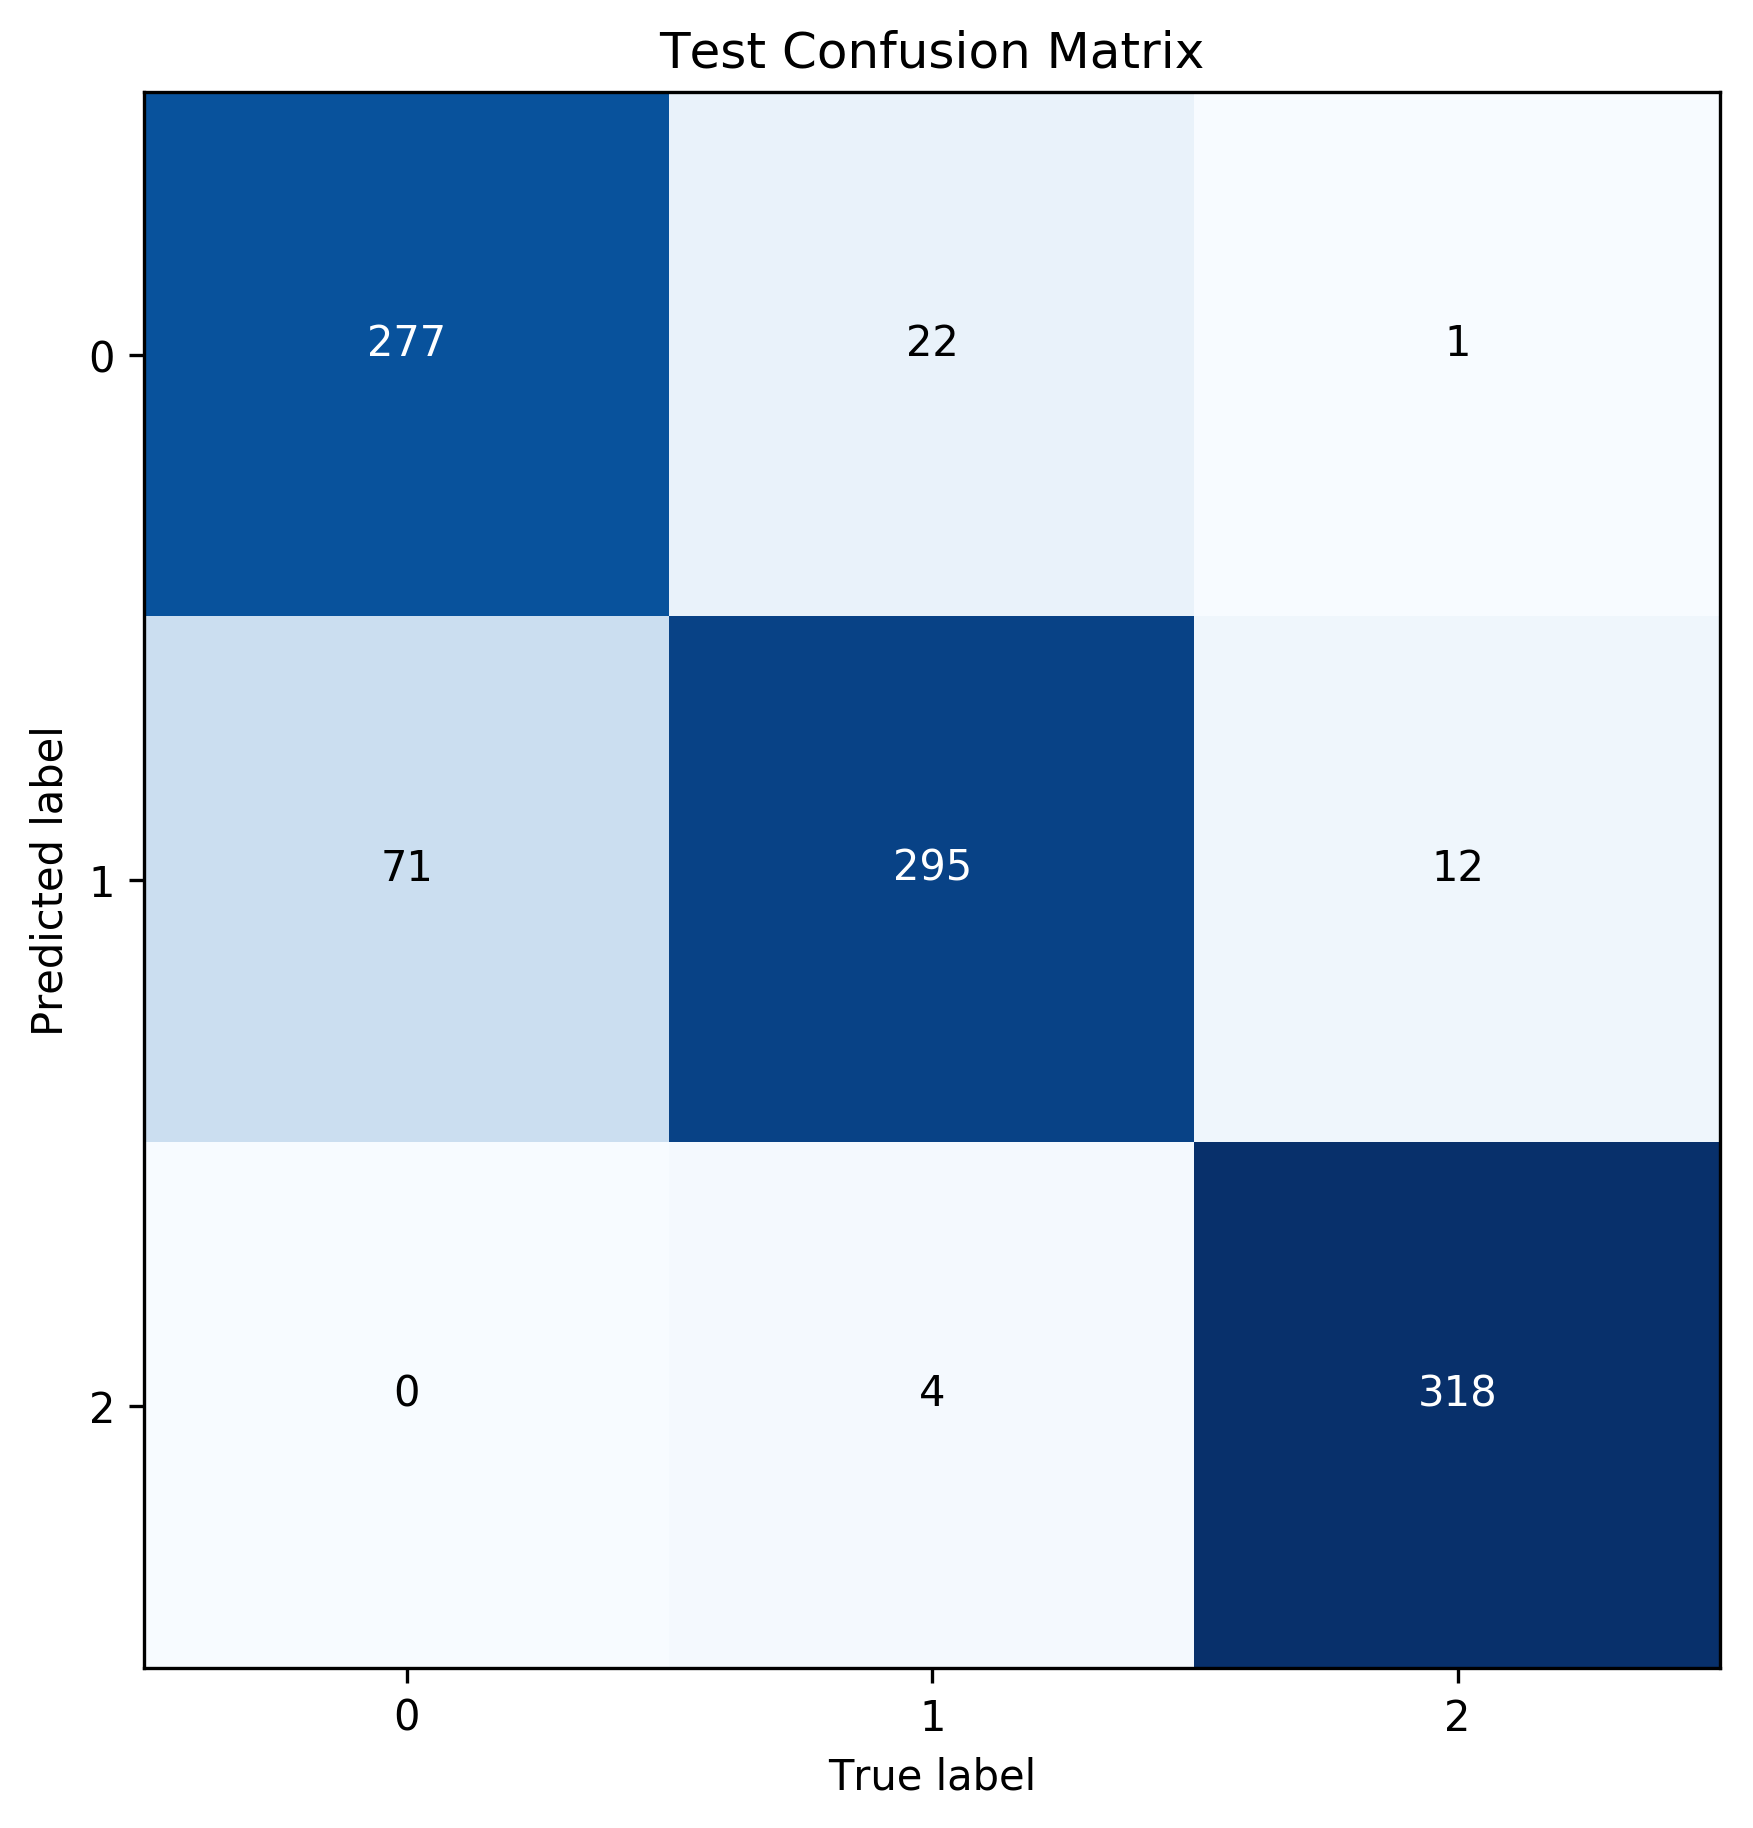

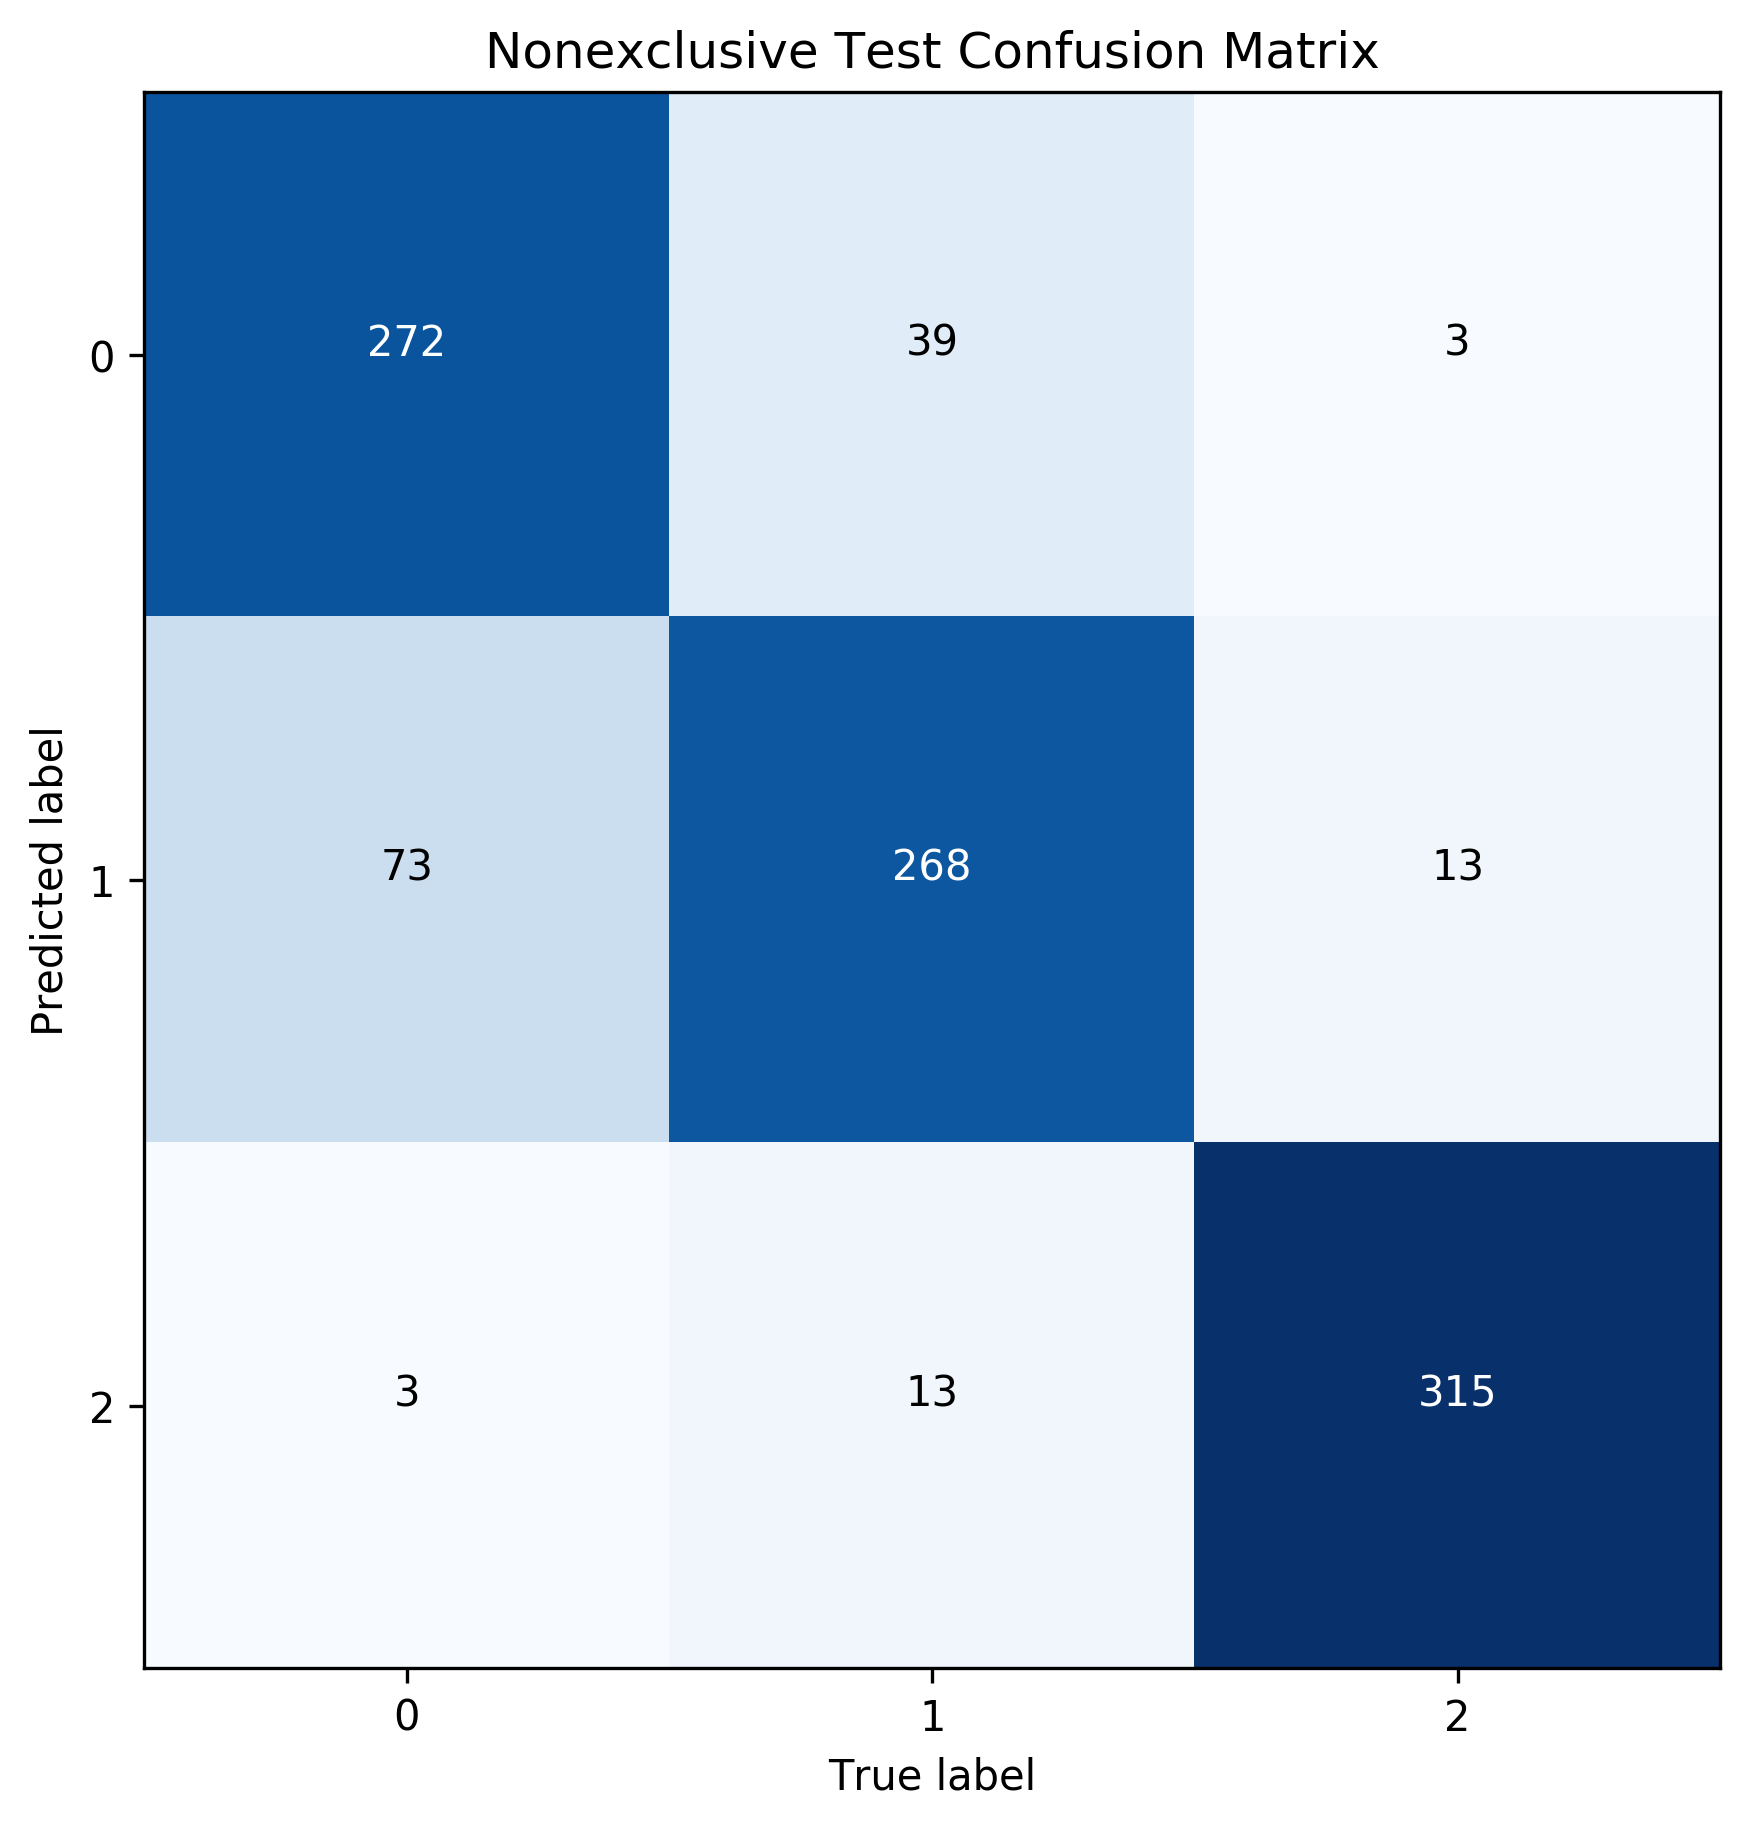

In [15]:
# Alternately train and evaluate the net for 20 minutes.
from src import visualization
importlib.reload(visualization)
from IPython import display

TRAIN_MINS = 20
REPORT_MINS = 4
SECS_PER_MIN = 60

for _ in range(TRAIN_MINS // REPORT_MINS):
    model.train(train, REPORT_MINS * SECS_PER_MIN)
    model.evaluate(metrics)
    display.clear_output()
    metrics["train_loss"].plot("Training Loss", "training examples seen", "cross-entropy loss on training data", 4, 10)
    metrics["test_loss"].plot("Test Loss", "training examples seen", "cross-entropy loss on test data", 4, 10)
    metrics["conf_mtx"].plot("Test Confusion Matrix", 6, 6)
    metrics["nx_conf_mtx"].plot("Nonexclusive Test Confusion Matrix", 6, 6)

# Testing

Lastly, we use the trained neural network to get the colony count of a plate image that was not used in training.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


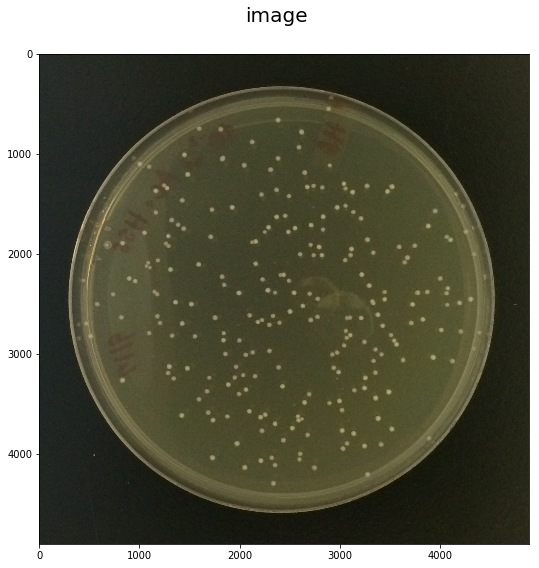

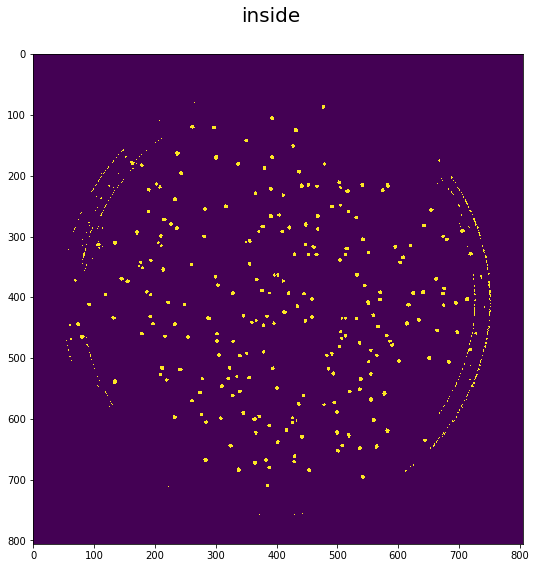

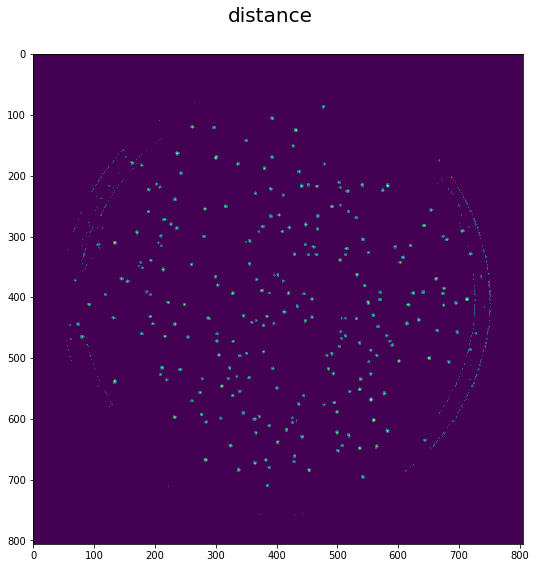

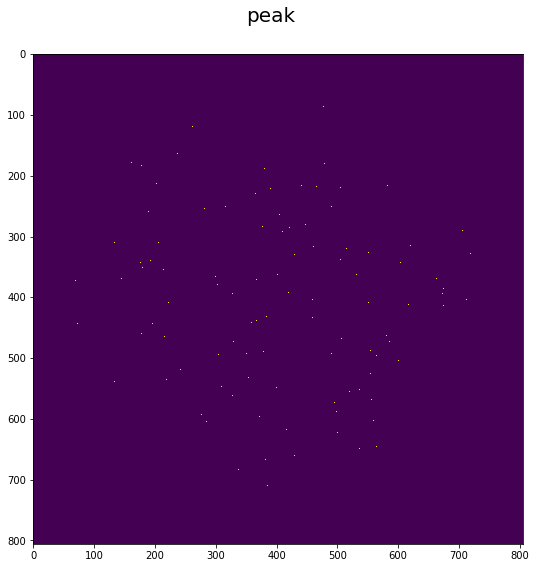

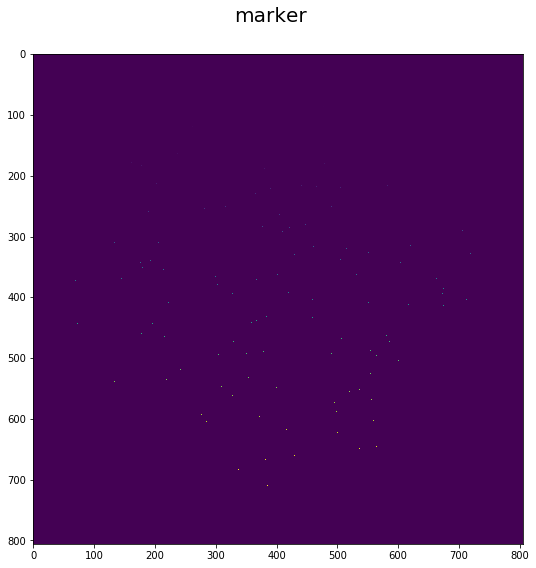

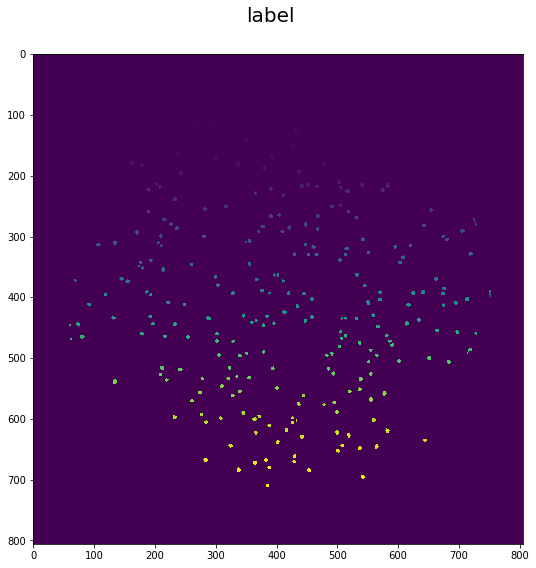

247

In [26]:
from src import postprocess
importlib.reload(postprocess)
from scipy import ndimage, misc
import numpy as np

TEST_IMAGE_PATH = "../../data/easy/raw/images/IMG_2519.JPG"
RESIZE_DIMS = (2*2448, 2*2448)
INTERP_TYPE = "bicubic"
PATCH_SIZE = 61
BATCH_SIZE = 3_000
SAMPLING_INTERVAL = int((2*2448) / 800)
MIN_DIST = max(int((11 * 2) / SAMPLING_INTERVAL), 1)
MIN_DIAM = (11 * 2) / SAMPLING_INTERVAL

def patch_classifier(patches):
    scores = model.predict(patches)
    return scores

image = ndimage.imread(TEST_IMAGE_PATH)
image = misc.imresize(image, RESIZE_DIMS, interp=INTERP_TYPE)
postprocess.count_regions(image, PATCH_SIZE, patch_classifier, BATCH_SIZE, MIN_DIST, MIN_DIAM, sampling_interval=SAMPLING_INTERVAL, debug=True)

The actual count is $243$, so this result is encouraging.